In [1]:
import asreview as asr

from asreview.models.balancers import Balanced
from asreview.models.queriers import Max

from asreview.models.classifiers import SVM
from asreviewcontrib.dory.classifiers.neural_networks import DynamicNNClassifier  # noqa:F401
from asreviewcontrib.dory.feature_extractors.transformer_embeddings import MXBAI

from sklearn.decomposition import NMF
from cockatiel.cockatiel.sampling import ScipySobolSequence
from cockatiel.cockatiel.sobol import SobolEstimator  # JansenEstimator
import matplotlib.pyplot as plt
import random

import numpy as np
import pandas as pd
from wordcloud import WordCloud as wc
from dataclasses import dataclass, field
import os

import nltk
from nltk.tokenize import sent_tokenize

nltk.download(info_or_id="punkt_tab")

2025-05-23 13:12:52,031 SequenceTagger predicts: Dictionary with 47 tags: O, S-NP, B-NP, E-NP, I-NP, S-VP, B-VP, E-VP, I-VP, S-PP, B-PP, E-PP, I-PP, S-ADVP, B-ADVP, E-ADVP, I-ADVP, S-SBAR, B-SBAR, E-SBAR, I-SBAR, S-ADJP, B-ADJP, E-ADJP, I-ADJP, S-PRT, B-PRT, E-PRT, I-PRT, S-CONJP, B-CONJP, E-CONJP, I-CONJP, S-INTJ, B-INTJ, E-INTJ, I-INTJ, S-LST, B-LST, E-LST, I-LST, S-UCP, B-UCP, E-UCP, I-UCP, <START>, <STOP>


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jelle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jelle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Jelle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
data = asr.load_dataset(r"data\van_der_Valk_2021.csv")

alc = asr.ActiveLearningCycle(
    # classifier=DynamicNNClassifier(),
    classifier=SVM(max_iter=5000, loss="squared_hinge", C=0.067),  # classifier c(x)
    feature_extractor=MXBAI(normalize=False),
    balancer=Balanced(ratio=9.724),
    querier=Max(),
)

In [3]:
embedding_path = "data/embedding_matrix.pkl"

if not os.path.exists(embedding_path):
    embedding_matrix = alc.transform(data)
    pd.DataFrame(embedding_matrix).to_pickle(embedding_path)
    embedding_matrix = np.array(embedding_matrix)
else:
    embedding_matrix = pd.read_pickle(embedding_path)
    embedding_matrix = np.array(embedding_matrix)


In [4]:
def normalize_embedding(fm) -> np.ndarray:
    return (fm - fm.min()) / (fm.max() - fm.min())


@dataclass
class EmbeddingNormalizer:
    base_embedding: np.ndarray
    embedding_min: float = field(init=False)
    embedding_max: float = field(init=False)

    def __post_init__(self):
        self.embedding_min = float(self.base_embedding.min())
        self.embedding_max = float(self.base_embedding.max())

    def normalize(self, embedding) -> np.ndarray:
        return (embedding - self.embedding_min) / (
            self.embedding_max - self.embedding_min
        )


embedding_normalizer = EmbeddingNormalizer(embedding_matrix)

normalized_embedding_matrix: np.ndarray = embedding_normalizer.normalize(
    embedding_matrix
)

In [5]:
simulate = asr.Simulate(  # c(A) in the cycler
    X=normalized_embedding_matrix,
    labels=data["included"],
    cycles=[alc],
    skip_transform=True,
)

simulate.label(list(range(10)))
simulate.review()


### Non-Negative Matrix ###


Records labeled       :  56%|█████▋    | 408/725 [00:22<00:17, 18.06it/s]


Loss: 0.139
NDCG: 0.729


In [ ]:
def get_proba_from_cycle(X: np.ndarray, simulate: asr.Simulate = simulate):
    try:
        proba = simulate.cycles[0].classifier.predict_proba(X)
        return proba

    except AttributeError:
        try:
            scores = simulate.cycles[0].classifier.decision_function(X).reshape(-1, 1)
            pos = np.maximum(scores, 0.0).reshape(-1, 1)
            neg = np.maximum(-scores, 0.0).reshape(-1, 1)
            return np.hstack([neg, pos])

        except AttributeError:
            raise AttributeError(
                "Not possible to compute probabilities or "
                "decision function for this classifier."
            )

# Cockatiel - positive

In [7]:
class JansenEstimator(SobolEstimator):
    def __call__(self, masks, outputs, nb_design):
        nb_dim = self.masks_dim(masks)
        sampling_a, _, replication_c = self.split_abc(outputs, nb_design, nb_dim)
        mu_a = np.mean(sampling_a)
        var = np.sum([(v - mu_a) ** 2 for v in sampling_a]) / (len(sampling_a) - 1)
        eps = 1e-12
        if var < eps:
            return np.zeros(nb_dim)
        stis = [
            np.sum((sampling_a - replication_c[i]) ** 2.0) / (2 * nb_design * var)
            for i in range(nb_dim)
        ]
        return self.post_process(stis, masks)


def sobol_importance(
    activations: np.ndarray,
    class_id: int,
    W: np.ndarray,
    components: int,
):
    sobol_nb_design: int = 64
    n_samples = activations.shape[0]
    masks = ScipySobolSequence()(components, nb_design=sobol_nb_design)
    estimator = JansenEstimator()

    importances = []

    for i in range(n_samples):
        act = activations[i]

        perturbation = masks @ W
        perturbated_activations = act[None, :] + perturbation * act[None, :]
        y_pred = get_proba_from_cycle(perturbated_activations)[:, class_id]

        stis = estimator(masks, y_pred, sobol_nb_design)
        importances.append(stis)

    global_importance = np.mean(importances, axis=0)

    return global_importance

In [8]:
pos_normalized_embedding_matrix = normalized_embedding_matrix[simulate.labels == 1]

In [9]:
# Do the NMF
factorization = NMF(n_components=20, max_iter=10000)

u_matrix: np.ndarray = factorization.fit_transform(
    pos_normalized_embedding_matrix
)  # concept coefficient matrix
w_matrix: np.ndarray = factorization.components_  # concept base matrix

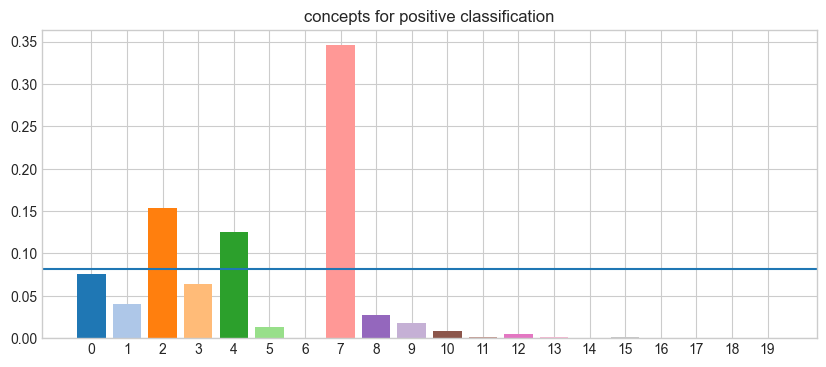

In [10]:
pos_concept_importance = sobol_importance(
    activations=pos_normalized_embedding_matrix,
    class_id=1,
    W=w_matrix,
    components=factorization.n_components,
)

plt.figure(figsize=(22, 4))

plt.subplot(122)
plt.bar(
    range(len(pos_concept_importance)),
    pos_concept_importance,
    color=plt.get_cmap("tab20").colors,
    tick_label=range(len(pos_concept_importance)),
)
plt.axhline(pos_concept_importance.std())
plt.title("concepts for positive classification")

plt.show()


In [11]:
# finding abstracts that align with concepts
df = data.get_df()[["title", "abstract"]]

# pos only
df = df[simulate.labels == 1]

# use the text merger part of the feature extractor to get the text column
df["text"] = (
    simulate.cycles[0]
    .feature_extractor.steps[0][1]
    .transform(df[["title", "abstract"]])
)

df["u"] = list(u_matrix)

df["a"] = list(pos_normalized_embedding_matrix)

df.head(4)

,title,abstract,text,u,a
4,"In adults with obesity, copeptin is linked wit...",Obesity and cardiometabolic diseases are assoc...,"In adults with obesity, copeptin is linked wit...","[0.0, 0.023716124, 0.0, 0.048237, 0.0096705025...","[0.3288705, 0.35569382, 0.3049634, 0.4518641, ..."
7,Hair cortisol levels in posttraumatic stress d...,Individuals with post-traumatic stress disorde...,Hair cortisol levels in posttraumatic stress d...,"[0.051770605, 0.016212694, 0.0, 0.07807395, 0....","[0.34883788, 0.2789237, 0.33446664, 0.43431118..."
21,Higher Cortisol Predicts Less Improvement in V...,Objective . While physical activity can improv...,Higher Cortisol Predicts Less Improvement in V...,"[0.014790181, 0.022473847, 0.004832791, 0.0, 0...","[0.37236753, 0.33805552, 0.3648011, 0.43693286..."
24,Simultaneous HPLC-APCI-MS/MS quantification of...,Hair matrix could retrospectively record assoc...,Simultaneous HPLC-APCI-MS/MS quantification of...,"[0.02784329, 0.010153167, 0.0033012861, 0.0169...","[0.36110023, 0.3878105, 0.33021107, 0.42159355..."


## Concept-Aligned Abstract Selection

The following code selects abstracts aligned with important concepts for each class. This is intended to support the visualization of concept-based occlusion as done in the COCKATIEL paper.

In the paper, the authors describe this step as:

    “We take the first n most important sentences for each concept looked at.”

However, this wording is misleading.

What the code actually does:

    It first identifies the top-m most important concepts for each class (m_cls_0 and m_cls_1) using the Sobol importance scores.

    Then, for each of these top concepts, it selects the n abstracts from the corresponding class (0 or 1) that have the highest activation for that concept (i.e., the highest coefficient in the NMF U matrix).

    The result is a list of m × n abstracts per class that best represent the most influential concepts, according to NMF.

Key clarification:

    The abstracts are not ranked globally by importance or fidelity to the model’s prediction.

    Instead, they are selected per concept, based on how strongly each abstract activates that concept.

In [25]:
len(df)

89

In [31]:
threshold = np.std(pos_concept_importance)
top_cids = np.where(pos_concept_importance > threshold)[0]

print(f"Selected {len(top_cids)} concepts")

rows = []
for cid in top_cids:
    best_ids = np.argsort(u_matrix[:, cid])[::-1][:round(len(df)/(2*len(top_cids)))]
    for i in best_ids:
        rows.append({"text": df.iloc[i]["text"], "concept_id": cid})

df_top_abs = pd.DataFrame(data=rows)


Selected 3 concepts


# Occlusion

In [13]:
simulate.cycles[0].feature_extractor.steps[1][1].verbose = False


def occlude_concepts(
    row,
    concept_ids,
    simulate=simulate,
    factorization=factorization,
) -> pd.DataFrame:
    sentences = sent_tokenize(row["text"])

    perturbed_texts = [
        " ".join(s for j, s in enumerate(sentences) if j != i)
        for i in range(len(sentences))
    ]

    # only use the transformer, not the text merger
    A_occluded = (
        simulate.cycles[0].feature_extractor.steps[1][1].fit_transform(perturbed_texts)
    )

    # Normalize using original min and max values, not the new ones!
    A_norm = embedding_normalizer.normalize(embedding=A_occluded)

    # project the whole batch to concept space
    U_occ = factorization.transform(A_norm)

    # ∆U: full – perturbed  (broadcasts row['u'])
    delta = row["u"] - U_occ

    # Only keep the columns for the selected concept_ids
    concept_cols = [f"concept_{i}" for i in concept_ids]
    delta_selected = delta[:, concept_ids]

    # normalize using the method cockatiel uses
    delta_selected /= np.max(np.abs(delta_selected)) + 1e-5

    delta_selected = np.clip(delta_selected, 0, 1)

    out = pd.DataFrame(delta_selected, columns=concept_cols)
    out.insert(0, "sentence", sentences)

    return out

## Visualization

In [39]:
from IPython.core.display import HTML

colors = np.array(
    [
        "rgba(9, 221, 55, ",  # green
        "rgba(9, 221, 161, ",  # turquoise
        "rgba(9, 175, 221, ",  # blue
        "rgba(9, 34, 221, ",  # purple
        "rgba(221, 9, 34, ",  # red
        "rgba(221, 9, 140,",  # pink
        "rgba(221, 90, 9, ",  # orange
    ]
)


def visualize_concepts(df: pd.DataFrame, threshold = 0.2):
    html = []

    concept_ids = df.columns[1:]

    for i, concept_id in enumerate(concept_ids):
        html.append(
            f'<span style="background-color: {colors[i]} 0.5); margin: 7px; padding: 1px 5px; border: solid 3px ; border-color: {colors[i]} 1); #EFEFEF">{concept_id} </span>'
        )
    display(
        HTML(
            "<div style='display: flex; width: 400px; flex-wrap: wrap;'>"
            + " ".join(html)
            + " </div>"
        )
    )

    html = []

    # Sentence-level highlighting
    for _, row in df.iterrows():
        sentence = row["sentence"]
        phi_vals = [row[cid] for cid in concept_ids]
        k = np.argmax(phi_vals)
        max_phi = phi_vals[k]
        if max_phi > threshold:
            html.append(
                f'<span style="display: inline; background-color: {colors[k]} {max_phi}); padding: 1px 5px; border: solid 3px ; border-color: {colors[k]} 1); #EFEFEF">{sentence}</span>'
            )
        else:
            html.append(
                f'<span style="display: inline; background-color: rgba(0, 0, 0, 0.1); padding: 1px 5px; border: solid 3px ; border-color: rgba(0, 0, 0, 0.1); #EFEFEF">{sentence}</span>'
            )
    display(
        HTML(
            "<div style='display: flex; width: 800px; flex-wrap: wrap;'>"
            + "".join(html)
            + " </div>"
        )
    )

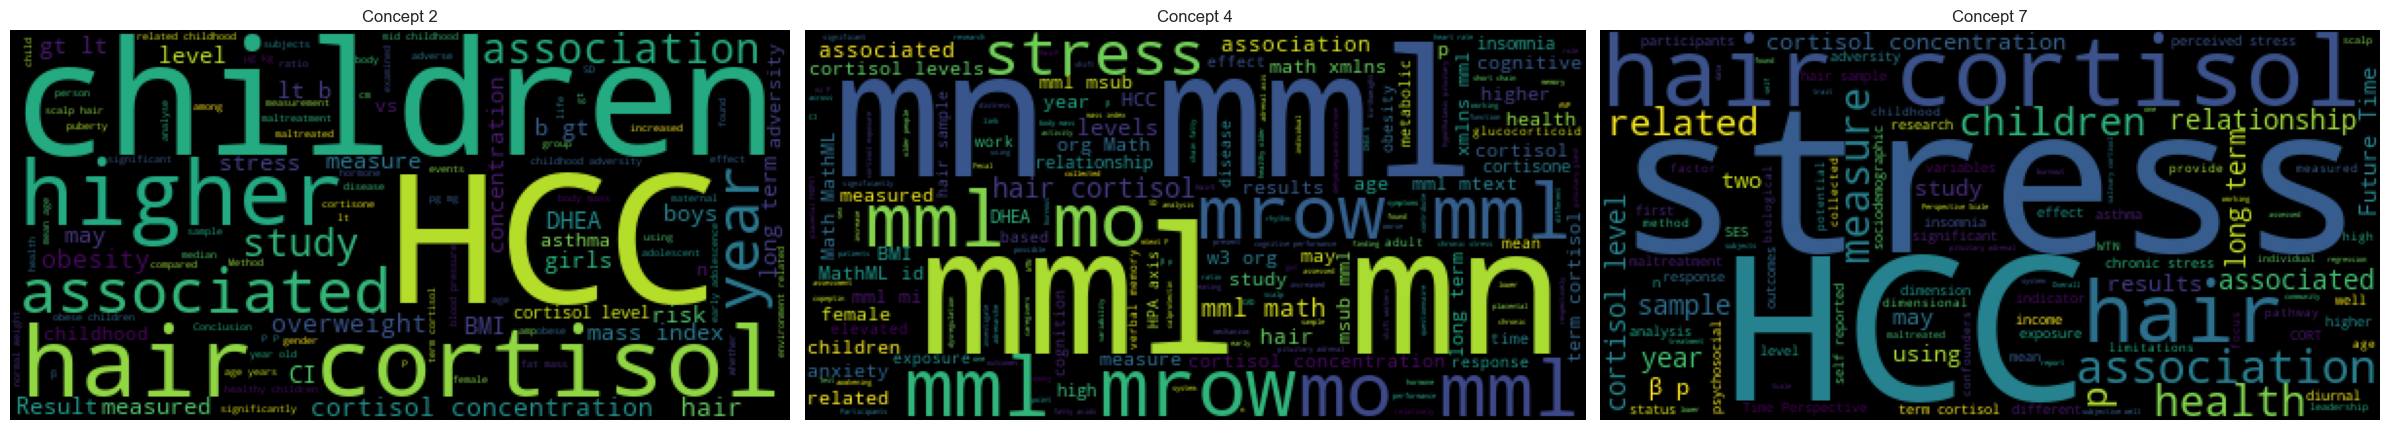

In [35]:
fig, axes = plt.subplots(1, len(top_cids), figsize=(24, 6))

for idx, concept in enumerate(top_cids):
    ax = axes[idx]
    ax.imshow(
        wc().generate(
            text=" ".join(df_top_abs[df_top_abs["concept_id"] == concept].text)
        )
    )
    ax.axis("off")
    ax.set_title(f"Concept {concept}")

plt.tight_layout()
plt.show()

In [42]:
visualize_concepts(occlude_concepts(df.iloc[random.randint(0, len(df) - 1)], top_cids), 0.3)